# TO DO 
- [ ] Fix recursion Problem

In [54]:
from functools import reduce, partial

import numpy as np
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt

import nifty8 as ift
import nifty8.re as jft
from nifty8.re.tree_math import ShapeWithDtype

import jubik0 as ju

seed = 42
key = random.PRNGKey(seed)

# Definitions

In [2]:
class MappedModel(jft.Model):
    def __init__(self, correlated_field, key, shape, first_axis=True):
        """
        Parameters:
        ----------
        correlated_field : CF Model
        cf_prefix: probably string 
        shape: tuple, number of copies in each dim
        first_axis: if True prepends the ndof copies els appends 
        """
        self._cf = correlated_field
        ndof = reduce(lambda x, y: x * y, shape)
        keys = correlated_field.domain.keys()

        xi_key = key
        #xi_key = cf_prefix+'xi'
        if xi_key not in keys:
            raise ValueError
            
        xi_dom = correlated_field.domain[xi_key]
        if first_axis:
            new_primals = jft.ShapeWithDtype((ndof,) + xi_dom.shape, xi_dom.dtype)
            axs = 0
            self._out_axs = 0
            self._shape = shape + correlated_field.target.shape
        else: 
            new_primals = jft.ShapeWithDtype(xi_dom.shape + (ndof,), xi_dom.dtype)
            axs = -1
            self._out_axs = 1
            self._shape = correlated_field.target.shape + shape

        new_domain = correlated_field.domain.copy()
        new_domain[xi_key] = new_primals
        
        xiinit = partial(jft.random_like, primals= new_primals)
        
        init = correlated_field.init
        init = {k: init[k] if k != xi_key else xiinit for k in keys}
              
        self._axs=({k: axs if k==xi_key else None for k in keys},)
        super().__init__(domain=new_domain, init=jft.Initializer(init))

    def __call__(self, x):
        x = x.tree if isinstance(x, jft.Vector) else x
        return (jax.vmap(self._cf, in_axes = self._axs, out_axes=self._out_axs)(x)).reshape(self._shape)    

In [3]:
class NCopiesCorrField():
    def __init__(self, cf, N_copies, prefix):
        """
        Parameters:
        ----------
        N_copies: Tuple of int,
                Shape of the new field, implicitely defining the Number of copies. 
                Each of the correlated fields has the same power spectrum,
                but different excitations.
        cf: Correlated Field Model,
            from nifty.re

        returns:
        -------
        Model for multiple CorrelatedFields with the same pspec 
        but different xi_s.     
        """
        self.cf = cf
        self.N_copies = N_copies
        self.number = reduce(lambda x, y: x * y, self.N_copies)
        self.xi_key = prefix+ "xi"
        self.n_xis = cf.domain[self.xi_key].size
        self.target_flatten = ShapeWithDtype(shape=(self.n_xis, self.number))
        self.target = ShapeWithDtype(shape=((self.n_xis,) + self.N_copies))
        self.new_domain = self._extend_xi_domain()
        
    def _partly_apply_cf(self, pos_init):
        def partly(xi, xi_key):
            pos_init.tree.pop(xi_key)
            pos_init.tree.update({xi_key: xi})
            return self.cf(pos_init)
        return partly
        
    def _extend_xi_domain(self):
        dict = self.cf.domain.copy()
        dict.update({self.xi_key: self.target_flatten})
        return dict

    def partial_init_ncopies_model(self, pos_new):
        func = self._partly_apply_cf(pos_new)
        ncopies_model_func = jax.vmap(func, in_axes=(1, None), out_axes=1)
        res = ncopies_model_func(pos_new.tree[self.xi_key], self.xi_key)
        return res.reshape(self.cf.target.shape + self.N_copies)

    def build_model(self):       
        return jft.Model(self.partial_init_ncopies_model,
                         domain=self.new_domain,
                         target=self.target)

In [49]:
class General_Model(jft.Model):
    def __init__(self, dict_of_fields = {}):
        self._available_fields = dict_of_fields
        
    def build_model(self):
        def add_functions(f1, f2):
            def function(x):
                return f1(x) + f2(x)
            return function
            
        if 'spatial' not in self._available_fields.keys() or self._available_fields['spatial'] is None:
            raise NotImplementedError
        else:
            spatial = self._available_fields['spatial']
            func = spatial
            domain = spatial.domain
            if 'freq_plaw' in self._available_fields.keys() and self._available_fields['freq_plaw'] is not None:
                plaw = self._available_fields['freq_plaw']
                func = add_functions(func, plaw)
                #func = lambda x: plaw(x) + spatial(x)
                domain = domain | plaw.domain
            if 'freq_dev' in self._available_fields.keys() and self._available_fields['freq_dev'] is not None:
                dev = self._available_fields['freq_dev']
                
                def extract_keys(a, domain):
                    b = {key: a[key] for key in domain}
                    return b
                    
                def extracted_dev(op):
                    def callable_dev(x):
                        return op(extract_keys(x), op.domain)
                    return callable_dev
                    
                func = add_functions(func, extracted_dev(dev))
                #func = lambda x: func(x) + dev(extract_keys(x, dev.domain))
                domain = domain | dev.domain
            if 'pol' in self._available_fields.keys() and self._available_fields['pol'] is not None:
                raise NotImplementedError
            if 'time' in self._available_fields.keys() and self._available_fields['time'] is not None:
                raise NotImplementedError
            res = jft.Model(func, domain=domain)
        return res        

In [5]:
def build_power_law(freq, alph):
    if isinstance(alph, jft.Model):
        res = lambda x: jnp.outer(freqs, alph(x)).reshape(freqs.shape + alph.target.shape)
    elif isinstance(alph, float):
        res = jnp.outer(freqs, alph).reshape(freqs.shape) # FIXME
    print(res)
    return jft.Model(res, domain=alph.domain)

# Fields

In [6]:
e_dims = (12)
s_dims = (512,512)

RG_Energies = True
if RG_Energies:
    freqs = jnp.arange(0,12)
else:
    freqs = jnp.array([1,3,4,7,12,17,19.3])

## Spatial field

In [14]:
cf_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
cf_fl = {
    "fluctuations": (1.0, 5e-3),
    "loglogavgslope": (-3., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": None,
    "harmonic_type": "Fourier"
}
cfm = jft.CorrelatedFieldMaker("space_cf")
cfm.set_amplitude_total_offset(**cf_zm)
cfm.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **cf_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
correlated_field = cfm.finalize()

## Deviations from Powerlaw

In [15]:
dev_zm = {"offset_mean": 0., "offset_std": (1e-3, 1e-4)}
dev_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e-3, 5e-1),
    "asperity": None,
    "harmonic_type": "Fourier"}
dev_cfm = jft.CorrelatedFieldMaker("dev_cf")
dev_cfm.set_amplitude_total_offset(**dev_zm)
dev_cfm.add_fluctuations(
    e_dims,
    distances=1. / e_dims,
    **dev_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
dev_correlated_field = dev_cfm.finalize()

## Spectral Index $\alpha$

In [16]:
alpha_zm = {"offset_mean": -2.0, "offset_std": (1e-3, 1e-4)}
alpha_fl = {
    "fluctuations": (1e-1, 5e-3),
    "loglogavgslope": (-1., 1e-2),
    "flexibility": (1e+0, 5e-1),
    "asperity": (5e-1, 5e-2),
    "harmonic_type": "Fourier"
}
alpha = jft.CorrelatedFieldMaker("alpha")
alpha.set_amplitude_total_offset(**alpha_zm)
alpha.add_fluctuations(
    s_dims,
    distances=1. / s_dims[0],
    **alpha_fl,
    prefix="ax1",
    non_parametric_kind="power"
)
alpha_field = alpha.finalize()

# Build Power Law

In [17]:
plaw = build_power_law(freqs, alpha_field)

<function build_power_law.<locals>.<lambda> at 0x75e46c015360>


## Margret und Vincent - Code

In [18]:
prefix = "dev_cf"
n_copies_model = NCopiesCorrField(dev_correlated_field, s_dims, prefix)
n_copies_model.number
cf_split = n_copies_model.build_model()

## Derived from Philipps Code

In [19]:
my_cf = MappedModel(dev_correlated_field, "dev_cfxi", s_dims, False)

In [20]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, my_cf.domain))

In [22]:
# LEGACY
# final_model = mf_model(freqs, alpha_field, correlated_field, my_cf)

In [24]:
#LEGACY

#key, subkey = random.split(key)
#pos_init = jft.Vector(jft.random_like(subkey, final_model.domain))
#final_model(pos_init).shape
#beautiful_image = final_model(pos_init)[0, :, :]
#fullfield = final_model(pos_init)

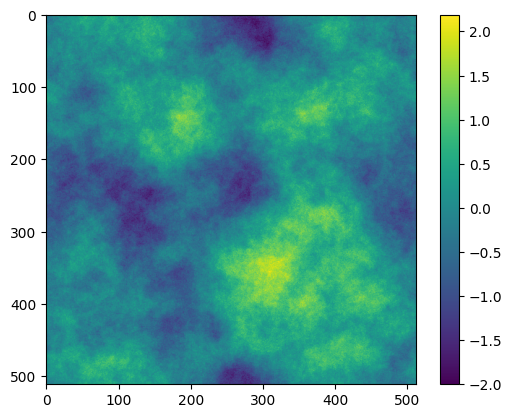

In [263]:
import matplotlib.pyplot as plt
plt.imshow(beautiful_image)
plt.colorbar()
plt.show()
plt.close()

In [250]:
#key, subkey = random.split(key)
#pos_init = jft.Vector(jft.random_like(subkey, correlated_field.domain))
sample = correlated_field(pos_init)

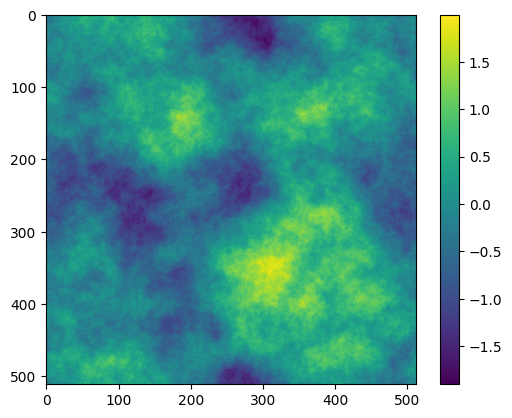

In [262]:
import matplotlib.pyplot as plt
plt.imshow(sample)
plt.colorbar()
plt.show()
plt.close()

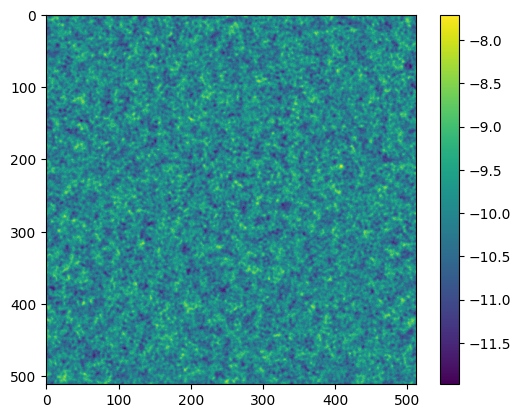

In [261]:
import matplotlib.pyplot as plt
plt.imshow(final_model(pos_init)[5, :, :]-sample)
plt.colorbar()
plt.show()
plt.close()

In [252]:
#key, subkey = random.split(key)
#pos_init = jft.Vector(jft.random_like(subkey, alpha_field.domain))
sample_alpha = alpha_field(pos_init)

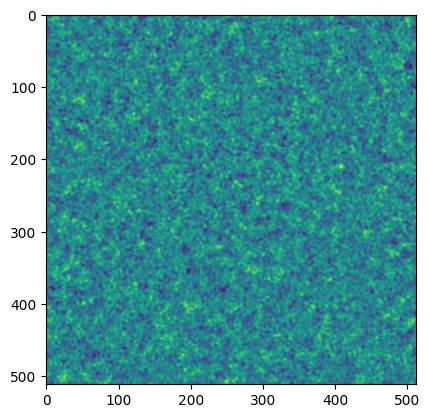

In [253]:
plt.imshow(sample_alpha)
plt.show()
plt.close()

In [254]:
def test_model(freqs, alph, spatial):
    plaw = lambda x: jnp.outer(freqs, alph(x)).reshape(freqs.shape + alph.target.shape)
    plaw_offset = lambda x: plaw(x) + spatial(x)
    domain = alph.domain | spatial.domain
    return jft.Model(plaw_offset, domain)

In [145]:
dev = jft.WienerProcess((0, 1), (1, 3), 2, name="marcent", N_steps=e_dims-1)

In [146]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, dev.domain))

In [147]:
dev.target

ShapeDtypeStruct(shape=(12,), dtype=float64)

In [148]:
dev(pos_init).shape

(12,)

In [149]:
haargret = MappedModel(dev, "marcent", s_dims, False)

In [150]:
final_gp_model = mf_model(freqs, alpha_field, correlated_field, haargret)

<class 'nifty8.re.model.Model'>


In [153]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, final_gp_model.domain))
more_beautiful_image = final_gp_model(pos_init)

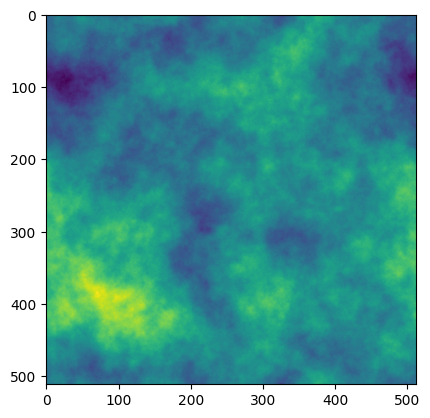

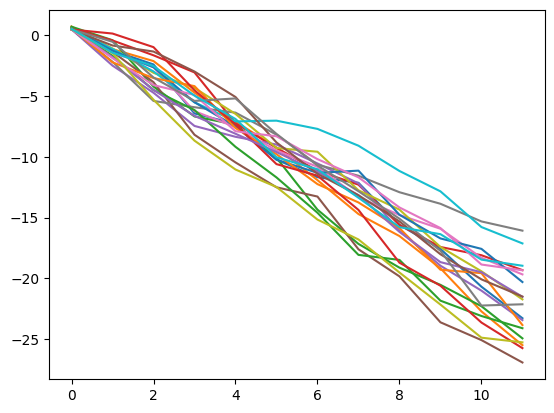

In [154]:
plt.imshow(more_beautiful_image[0,:,:])
plt.show()
plt.close()
for i in range(20):
    plt.plot(freqs,more_beautiful_image[:,i,10])
plt.show()
plt.close()

# New Model

In [50]:
gen_mod = General_Model({'spatial': correlated_field, 'freq_plaw': plaw, 'freq_dev':None}).build_model()

In [52]:
key, subkey = random.split(key)
pos_init = jft.Vector(jft.random_like(subkey, gen_mod.domain))
result = gen_mod(pos_init)

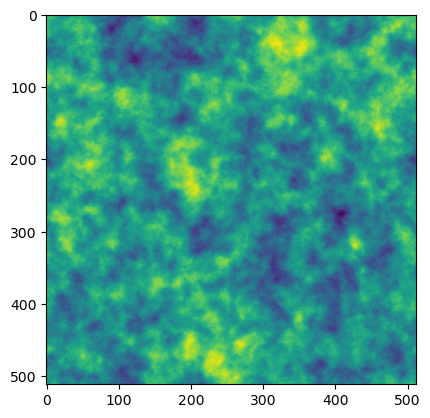

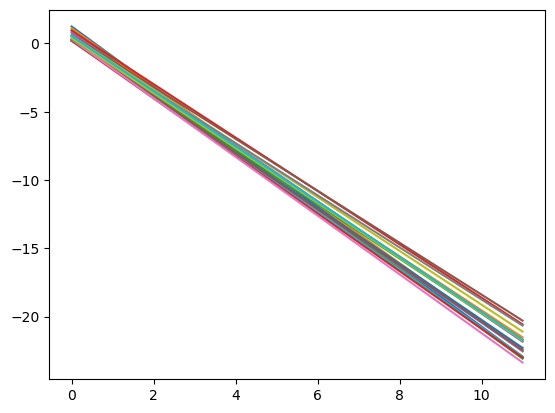

In [56]:
plt.imshow(result[1,:,:])
plt.show()
plt.close()
for i in range(20):
    plt.plot(freqs,result[:,i,10])
plt.show()
plt.close()

# Thats what we do

In [28]:
f = lambda x: x+1

In [31]:
f = lambda x: f(x)+1

In [32]:
f(1)

RecursionError: maximum recursion depth exceeded

# Thats what it means

In [33]:
def add_processes(process1, process2):
    def function(x):
        return process1(x) + process2(x)
    return function

In [36]:
def add_another_process(x):
    res = f
    return reds

In [37]:
g(1)

RecursionError: maximum recursion depth exceeded

# Thats what we actually want to do

# Ncopies with Nifty

we could remove this?

In [ ]:
import nifty8 as ift

sp1 = ift.RGSpace([10])
cfmaker = ift.CorrelatedFieldMaker('', total_N=100)
cfmaker.add_fluctuations(sp1, (0.1, 1e-2), (2, .2), (.01, .5), (-4, 2.),
                             'amp1')
cfmaker.set_amplitude_total_offset(0., (1e-2, 1e-6))
correlated_field = cfmaker.finalize()